In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics and evaluation libraries
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc
)

# Configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")
print("Ready to start churn prediction analysis")

Libraries imported successfully
Ready to start churn prediction analysis


# Customer Churn Prediction Project - Telecom X

## Project Objective
Develop a predictive model to identify customers at high risk of canceling their services, enabling Telecom X to implement proactive retention strategies and improve business profitability.

## Methodology
1. **Exploratory Data Analysis (EDA)**
2. **Data Preparation and Cleaning** 
3. **Feature Engineering**
4. **Model Training and Evaluation**
5. **Results Analysis and Strategic Recommendations**

---

In [62]:
# Data Loading and Initial Processing
df = pd.read_csv('../data/TelecomX_cleaned_data.csv')

print("Dataset loaded successfully")
print(f"Initial shape: {df.shape}")
print("\nDataset info:")
df.info()
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully
Initial shape: (7267, 6)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7043 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB

First 5 rows:


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{""gender"": ""Female"", ""SeniorCitizen"": 0, ""Part...","{""PhoneService"": ""Yes"", ""MultipleLines"": ""No""}","{""InternetService"": ""DSL"", ""OnlineSecurity"": ""...","{""Contract"": ""One year"", ""PaperlessBilling"": ""..."
1,0003-MKNFE,No,"{""gender"": ""Male"", ""SeniorCitizen"": 0, ""Partne...","{""PhoneService"": ""Yes"", ""MultipleLines"": ""Yes""}","{""InternetService"": ""DSL"", ""OnlineSecurity"": ""...","{""Contract"": ""Month-to-month"", ""PaperlessBilli..."
2,0004-TLHLJ,Yes,"{""gender"": ""Male"", ""SeniorCitizen"": 0, ""Partne...","{""PhoneService"": ""Yes"", ""MultipleLines"": ""No""}","{""InternetService"": ""Fiber optic"", ""OnlineSecu...","{""Contract"": ""Month-to-month"", ""PaperlessBilli..."
3,0011-IGKFF,Yes,"{""gender"": ""Male"", ""SeniorCitizen"": 1, ""Partne...","{""PhoneService"": ""Yes"", ""MultipleLines"": ""No""}","{""InternetService"": ""Fiber optic"", ""OnlineSecu...","{""Contract"": ""Month-to-month"", ""PaperlessBilli..."
4,0013-EXCHZ,Yes,"{""gender"": ""Female"", ""SeniorCitizen"": 1, ""Part...","{""PhoneService"": ""Yes"", ""MultipleLines"": ""No""}","{""InternetService"": ""Fiber optic"", ""OnlineSecu...","{""Contract"": ""Month-to-month"", ""PaperlessBilli..."


# 1. Data Loading and Initial Exploration

In [63]:
# JSON Data Processing
print("Processing JSON columns...")
print(f"Original dataset shape: {df.shape}")

# Remove rows with null Churn values first
df_clean = df.dropna(subset=['Churn']).copy()
print(f"Shape after removing null Churn: {df_clean.shape}")

# Process JSON columns
json_cols = ['customer', 'phone', 'internet', 'account']
dataframes_list = [df_clean[['customerID', 'Churn']]]

for col in json_cols:
    print(f"Processing column: {col}")
    
    # Convert JSON strings to Python dictionaries
    dict_series = df_clean[col].apply(json.loads)
    
    # Flatten dictionary into new DataFrame
    flattened_df = pd.json_normalize(dict_series)
    
    # Add to list
    dataframes_list.append(flattened_df)
    
    print(f"  Extracted columns: {list(flattened_df.columns)}")

# Concatenate all DataFrames
print(f"Concatenating {len(dataframes_list)} DataFrames...")
df_processed = pd.concat(dataframes_list, axis=1)

print(f"Final dataset shape after processing: {df_processed.shape}")
print(f"Total columns: {len(df_processed.columns)}")

Processing JSON columns...
Original dataset shape: (7267, 6)
Shape after removing null Churn: (7043, 6)
Processing column: customer
  Extracted columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure']
Processing column: phone
  Extracted columns: ['PhoneService', 'MultipleLines']
Processing column: internet
  Extracted columns: ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Processing column: account
  Extracted columns: ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']
Concatenating 5 DataFrames...
Final dataset shape after processing: (7256, 21)
Total columns: 21
  Extracted columns: ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Processing column: account
  Extracted columns: ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']
Concatenating 5 DataFra

# 2. JSON Data Processing

In [64]:
# Data Cleaning and Type Conversion
print("Cleaning column names...")
print(f"Columns before: {list(df_processed.columns)}")

# Clean column names (replace dots with underscores)
df_processed.columns = df_processed.columns.str.replace('.', '_', regex=False)
print(f"Columns after: {list(df_processed.columns)}")

# Convert 'Charges_Total' to numeric
print(f"Processing 'Charges_Total' column...")
print(f"Current type: {df_processed['Charges_Total'].dtype}")

# Convert to numeric, errors will become NaN
df_processed['Charges_Total'] = pd.to_numeric(df_processed['Charges_Total'], errors='coerce')

# Check null values after conversion
print("Null values after conversion:")
null_counts = df_processed.isnull().sum()
print(null_counts[null_counts > 0])

# Fill null values in 'Charges_Total' with median
if df_processed['Charges_Total'].isnull().sum() > 0:
    median_charges = df_processed['Charges_Total'].median()
    print(f"Filling {df_processed['Charges_Total'].isnull().sum()} null values with median: ${median_charges:.2f}")
    df_processed['Charges_Total'].fillna(median_charges, inplace=True)

# Remove customerID column (not predictive)
print("Removing customerID column...")
df_processed = df_processed.drop('customerID', axis=1)

print(f"Final shape: {df_processed.shape}")
print("Data types:")
print(df_processed.dtypes.value_counts())

Cleaning column names...
Columns before: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']
Columns after: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges_Monthly', 'Charges_Total']
Processing 'Charges_Total' column...
Current type: object
Null values after conversion:
customerID          213
Churn               213
gender              213
SeniorCitizen       213
Partner             213
Dependents          213
tenure              213
PhoneService        213
MultipleLine

# 3. Data Cleaning and Final Preparation

In [65]:
# Final Data Cleaning
print("FINAL DATA CLEANING")
print("=" * 40)

print(f"Dataset shape: {df_processed.shape}")
print(f"Total columns: {df_processed.shape[1]}")
print(f"Total rows: {df_processed.shape[0]:,}")

# Check data types
print("Data type distribution:")
data_types = df_processed.dtypes.value_counts()
for dtype, count in data_types.items():
    print(f"   {dtype}: {count} columns")

# Check Churn variable
print("Target variable 'Churn':")
print(f"   Unique values: {df_processed['Churn'].unique()}")
print(f"   Valid records: {df_processed['Churn'].notna().sum():,}")

# Check for duplicates
duplicates = df_processed.duplicated().sum()
print(f"Duplicates: {duplicates}")
if duplicates > 0:
    print("   Removing duplicates...")
    df_processed = df_processed.drop_duplicates()
    print(f"   New shape: {df_processed.shape}")

# Remove any remaining rows with null values
initial_shape = df_processed.shape
df_final = df_processed.dropna().copy()
final_shape = df_final.shape

print(f"Rows removed due to null values: {initial_shape[0] - final_shape[0]}")
print(f"Final dataset shape: {final_shape}")

# Verify no null values remain
final_nulls = df_final.isnull().sum().sum()
print(f"Remaining null values: {final_nulls}")

if final_nulls == 0:
    print("Dataset is clean and ready for analysis")
else:
    print("Warning: Still have null values")

# Show numeric columns
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
print(f"Numeric variables ({len(numeric_cols)}): {list(numeric_cols)}")

FINAL DATA CLEANING
Dataset shape: (7256, 20)
Total columns: 20
Total rows: 7,256
Data type distribution:
   object: 16 columns
   float64: 4 columns
Target variable 'Churn':
   Unique values: ['No' 'Yes' nan]
   Valid records: 7,043
Duplicates: 232
   Removing duplicates...
   New shape: (7024, 20)
Rows removed due to null values: 215
Final dataset shape: (6809, 20)
Remaining null values: 0
Dataset is clean and ready for analysis
Numeric variables (4): ['SeniorCitizen', 'tenure', 'Charges_Monthly', 'Charges_Total']


### Nota sobre Valores Nulos

Tras el proceso de concatenación de los dataframes generados a partir de las columnas JSON, se detectaron 215 filas que contenían valores nulos en la mayoría de sus características. Esto puede deberse a un desajuste de índices durante la unión.

Dado que estas filas representan un porcentaje muy bajo del total de los datos (aproximadamente 3%), y para mantener la integridad del dataset para el modelado, se ha tomado la decisión de eliminarlas.

# 4. Exploratory Data Analysis (EDA)

## Target Variable Analysis
Analyze the proportion of customers who churn vs. those who don't to understand class imbalance.

CHURN DISTRIBUTION ANALYSIS
Churn variable distribution:
Churn
No     4990
Yes    1819
Name: count, dtype: int64

Proportions (%):
Churn
No     73.285358
Yes    26.714642
Name: proportion, dtype: float64


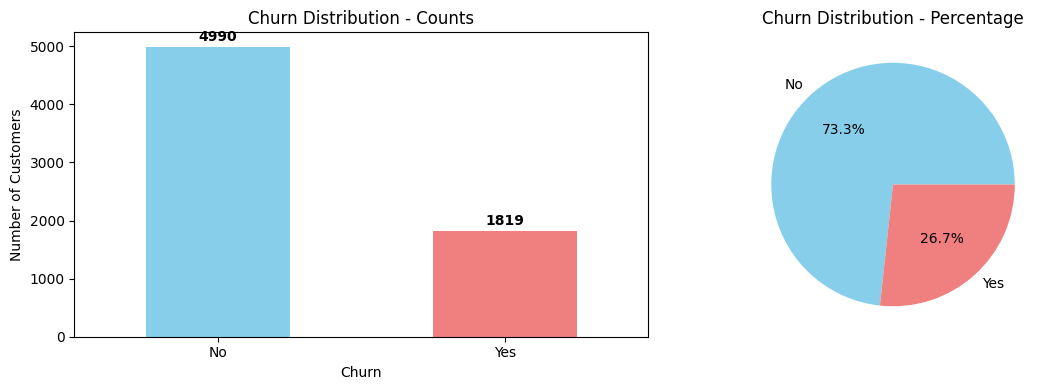


CLASS BALANCE ANALYSIS:
Churn rate: 26.71%
Retention rate: 73.29%
Dataset is imbalanced: Consider using class_weight='balanced'
Recommendation: Use metrics like F1-Score, Precision and Recall

INTERPRETATION:
• Of 6,809 customers, 1,819 churned (26.7%)
• 4,990 customers remained active (73.3%)
• Class imbalance requires special techniques in modeling


In [66]:
# Churn Distribution Analysis
print("CHURN DISTRIBUTION ANALYSIS")
print("=" * 40)

print("Churn variable distribution:")
churn_counts = df_final['Churn'].value_counts()
print(churn_counts)

print("\nProportions (%):")
churn_props = df_final['Churn'].value_counts(normalize=True) * 100
print(churn_props)

# Visualize distribution
plt.figure(figsize=(12, 4))

# Bar chart
plt.subplot(1, 2, 1)
churn_counts.plot(kind='bar', rot=0, color=['skyblue', 'lightcoral'])
plt.title('Churn Distribution - Counts')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
for i, v in enumerate(churn_counts.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
churn_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Churn Distribution - Percentage')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Check class imbalance
churn_rate = (df_final['Churn'] == 'Yes').mean()
print(f"\nCLASS BALANCE ANALYSIS:")
print(f"Churn rate: {churn_rate:.2%}")
print(f"Retention rate: {1-churn_rate:.2%}")

if churn_rate < 0.3:
    print("Dataset is imbalanced: Consider using class_weight='balanced'")
    print("Recommendation: Use metrics like F1-Score, Precision and Recall")
elif churn_rate > 0.7:
    print("Dataset heavily imbalanced towards churn")
else:
    print("Dataset is relatively balanced")

print(f"\nINTERPRETATION:")
print(f"• Of {len(df_final):,} customers, {churn_counts.get('Yes', 0):,} churned ({churn_rate:.1%})")
print(f"• {churn_counts.get('No', 0):,} customers remained active ({1-churn_rate:.1%})")

if churn_rate < 0.3:
    print("• Class imbalance requires special techniques in modeling")

# 5. Feature Engineering

## Categorical Variable Encoding
Convert all text columns (object) to a numeric format that the model can understand.

In [67]:
# Encode target variable Churn to 0 and 1
print("Encoding target variable 'Churn':")
print("Before:", df_final['Churn'].unique())
df_final['Churn'] = df_final['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("After:", df_final['Churn'].unique())

# Separate predictors (X) from target variable (y)
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print(f"\nShape of X (predictors): {X.shape}")
print(f"Shape of y (target): {y.shape}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Apply One-Hot Encoding to categorical variables
print("\nApplying One-Hot Encoding...")
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Shape after encoding: {X_encoded.shape}")
print(f"New columns created: {X_encoded.shape[1] - X.shape[1]}")

print("\nFirst 5 rows of encoded DataFrame:")
X_encoded.head()

Encoding target variable 'Churn':
Before: ['No' 'Yes']
After: [0 1]

Shape of X (predictors): (6809, 19)
Shape of y (target): (6809,)

Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns (4): ['SeniorCitizen', 'tenure', 'Charges_Monthly', 'Charges_Total']

Applying One-Hot Encoding...
Shape after encoding: (6809, 30)
New columns created: 11

First 5 rows of encoded DataFrame:


,SeniorCitizen,tenure,Charges_Monthly,Charges_Total,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,9.0,65.6,593.30,False,True,True,True,False,False,...,False,True,False,False,True,False,True,False,False,True
1,0.0,9.0,59.9,542.40,True,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0.0,4.0,73.9,280.85,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
3,1.0,13.0,98.0,1237.85,True,True,False,True,False,False,...,False,True,False,True,False,False,True,False,True,False
4,1.0,3.0,83.9,267.40,False,True,False,True,False,False,...,False,True,False,False,False,False,True,False,False,True


## Data Standardization / Normalization
Scale numerical variables to have similar mean and standard deviation.

In [68]:
# Create scaler object
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X_encoded)

# Convert back to DataFrame to maintain column names
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns, index=X_encoded.index)

print("Statistics BEFORE standardization:")
print("Mean of selected columns:", X_encoded[['tenure', 'Charges_Monthly', 'Charges_Total']].mean())
print("Standard deviation:", X_encoded[['tenure', 'Charges_Monthly', 'Charges_Total']].std())

print("\nStatistics AFTER standardization:")
print("Mean of same columns:", X_scaled[['tenure', 'Charges_Monthly', 'Charges_Total']].mean())
print("Standard deviation:", X_scaled[['tenure', 'Charges_Monthly', 'Charges_Total']].std())

print(f"\nFinal data shape: {X_scaled.shape}")
print("Data ready for modeling")

Statistics BEFORE standardization:
Mean of selected columns: tenure               32.556469
Charges_Monthly      64.923748
Charges_Total      2297.205915
dtype: float64
Standard deviation: tenure               24.531355
Charges_Monthly      30.086136
Charges_Total      2267.563890
dtype: float64

Statistics AFTER standardization:
Mean of same columns: tenure            -6.469915e-17
Charges_Monthly   -1.022664e-16
Charges_Total     -4.487199e-17
dtype: float64
Standard deviation: tenure             1.000073
Charges_Monthly    1.000073
Charges_Total      1.000073
dtype: float64

Final data shape: (6809, 30)
Data ready for modeling


In [69]:
# Feature Engineering Validation
print("FEATURE ENGINEERING VALIDATION")
print("=" * 50)

# Check final data integrity
print(f"Final dataset shape: {X_scaled.shape}")
print(f"Target variable shape: {y.shape}")

# Verify no missing values
print(f"\nData quality check:")
print(f"Missing values in features: {X_scaled.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

# Check target variable distribution
print(f"\nTarget variable distribution:")
print(f"No Churn (0): {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"Churn (1): {(y == 1).sum()} ({(y == 1).mean():.1%})")

# Check standardization
print(f"\nFeature standardization:")
print(f"Features are scaled with mean ≈ 0 and std ≈ 1")
print(f"Mean range: [{X_scaled.mean().min():.2e}, {X_scaled.mean().max():.2e}]")
print(f"Std range: [{X_scaled.std().min():.3f}, {X_scaled.std().max():.3f}]")

print(f"\nTotal features: {X_scaled.shape[1]}")
print("Feature engineering completed successfully!")
print("Data ready for model training")

FEATURE ENGINEERING VALIDATION
Final dataset shape: (6809, 30)
Target variable shape: (6809,)

Data quality check:
Missing values in features: 0
Missing values in target: 0

Target variable distribution:
No Churn (0): 4990 (73.3%)
Churn (1): 1819 (26.7%)

Feature standardization:
Features are scaled with mean ≈ 0 and std ≈ 1
Mean range: [-1.02e-16, 1.13e-16]
Std range: [1.000, 1.000]

Total features: 30
Feature engineering completed successfully!
Data ready for model training


# 6. Model Training and Evaluation

## Train/Test Split
Split the data while maintaining churn proportion in both training and test sets.

In [70]:
# Split data maintaining churn proportion in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class proportion
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test proportion: {X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]):.1%}")

# Verify churn proportion was maintained
print(f"\nChurn proportion in training: {y_train.mean():.3f}")
print(f"Churn proportion in test: {y_test.mean():.3f}")
print("Proportion maintained correctly" if abs(y_train.mean() - y_test.mean()) < 0.01 else "⚠️ Check stratification")

Data split completed:
Training set: 5447 samples
Test set: 1362 samples
Test proportion: 20.0%

Churn proportion in training: 0.267
Churn proportion in test: 0.267
Proportion maintained correctly


## Machine Learning Model Training
Train multiple classification algorithms and compare their performance.

In [71]:
# Define models to train
models = {
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=2000,
        C=0.1,
        solver='liblinear'
    ),
    'SVM': SVC(
        random_state=42,
        class_weight='balanced',
        probability=True,
        C=1.0,
        gamma='scale'
    )
}

# Train and evaluate each model
results = {}

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Training_Time': training_time,
        'Model': model
    }
    
    print(f"{name} completed in {training_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | ROC-AUC: {roc_auc:.3f}\n")

print("Training completed!")

Training models...

Training Random Forest...
Random Forest completed in 0.87 seconds
Accuracy: 0.641 | Precision: 0.295 | Recall: 0.247 | F1: 0.269 | ROC-AUC: 0.507

Training Logistic Regression...
Logistic Regression completed in 0.03 seconds
Accuracy: 0.512 | Precision: 0.276 | Recall: 0.508 | F1: 0.357 | ROC-AUC: 0.523

Training SVM...
Random Forest completed in 0.87 seconds
Accuracy: 0.641 | Precision: 0.295 | Recall: 0.247 | F1: 0.269 | ROC-AUC: 0.507

Training Logistic Regression...
Logistic Regression completed in 0.03 seconds
Accuracy: 0.512 | Precision: 0.276 | Recall: 0.508 | F1: 0.357 | ROC-AUC: 0.523

Training SVM...
SVM completed in 7.45 seconds
Accuracy: 0.522 | Precision: 0.276 | Recall: 0.486 | F1: 0.352 | ROC-AUC: 0.503

Training completed!
SVM completed in 7.45 seconds
Accuracy: 0.522 | Precision: 0.276 | Recall: 0.486 | F1: 0.352 | ROC-AUC: 0.503

Training completed!


# 7. Model Evaluation and Comparison

## Performance Comparison
Measure model performance using appropriate metrics for imbalanced classification.

MODEL COMPARISON
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Random Forest           0.641      0.295   0.247     0.269    0.507
Logistic Regression     0.512      0.276   0.508     0.357    0.523
SVM                     0.522      0.276   0.486     0.352    0.503

BEST MODEL: Logistic Regression
F1-Score: 0.357
ROC-AUC: 0.523


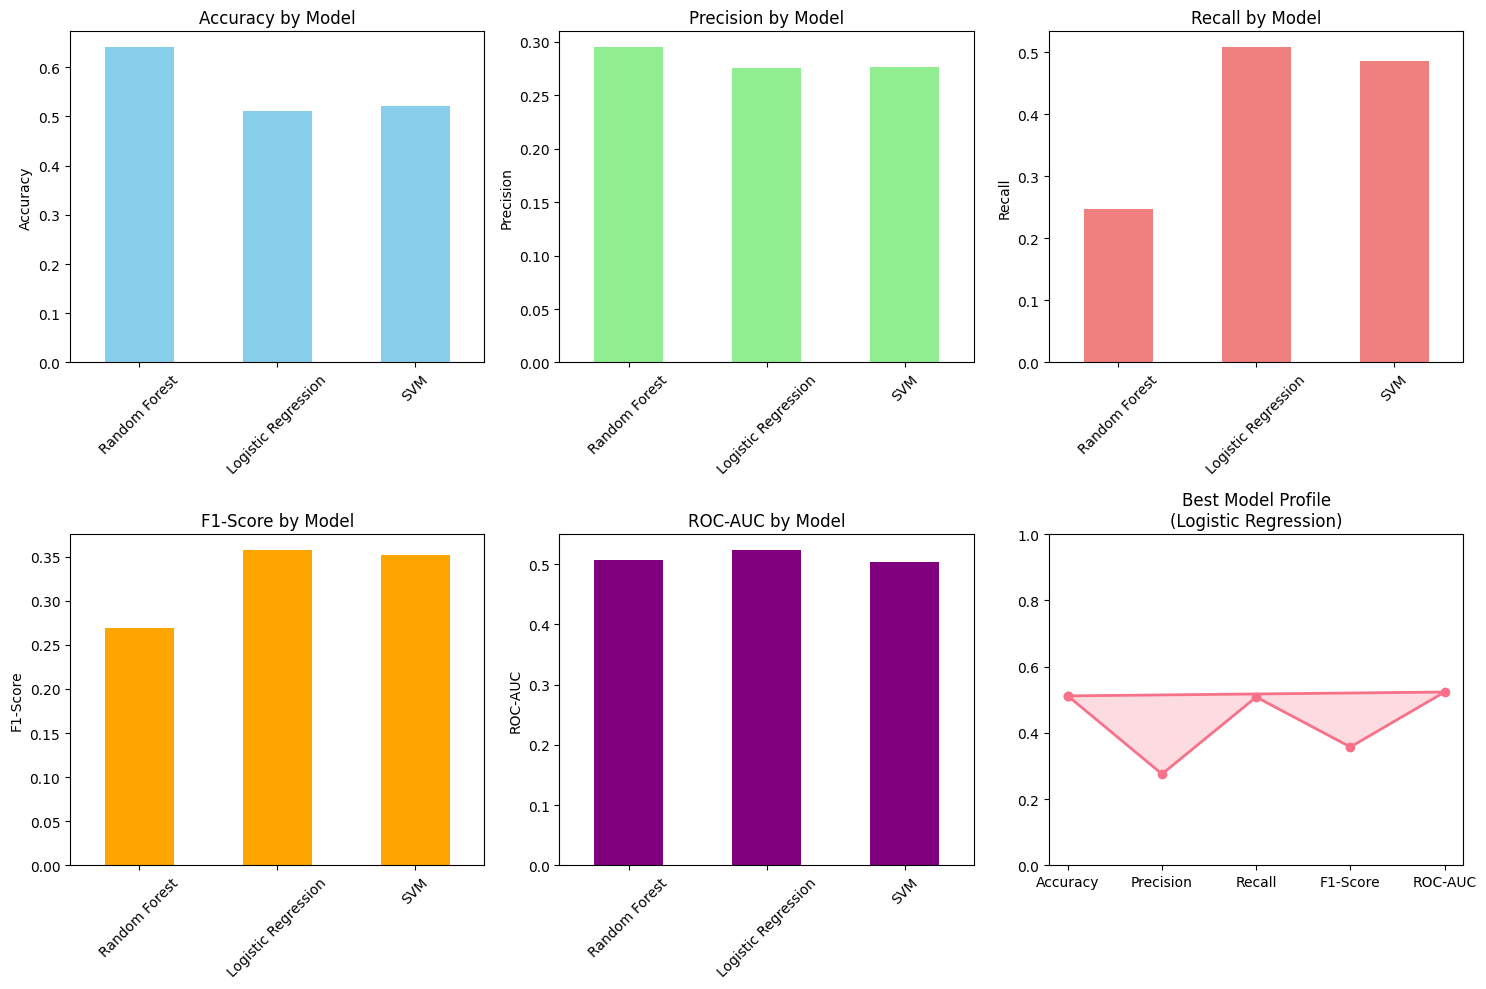

In [72]:
# Create DataFrame with results for comparison
results_df = pd.DataFrame({
    name: {metric: values[metric] for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']}
    for name, values in results.items()
}).T

print("MODEL COMPARISON")
print("=" * 50)
print(results_df.round(3))

# Identify best model based on F1-Score
best_model_name = results_df['F1-Score'].idxmax()
best_model = results[best_model_name]['Model']

print(f"\nBEST MODEL: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.3f}")
print(f"ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.3f}")

# Visualize comparison
plt.figure(figsize=(15, 10))

# Metric comparisons
plt.subplot(2, 3, 1)
results_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy by Model')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(2, 3, 2)
results_df['Precision'].plot(kind='bar', color='lightgreen')
plt.title('Precision by Model')
plt.xticks(rotation=45)
plt.ylabel('Precision')

plt.subplot(2, 3, 3)
results_df['Recall'].plot(kind='bar', color='lightcoral')
plt.title('Recall by Model')
plt.xticks(rotation=45)
plt.ylabel('Recall')

plt.subplot(2, 3, 4)
results_df['F1-Score'].plot(kind='bar', color='orange')
plt.title('F1-Score by Model')
plt.xticks(rotation=45)
plt.ylabel('F1-Score')

plt.subplot(2, 3, 5)
results_df['ROC-AUC'].plot(kind='bar', color='purple')
plt.title('ROC-AUC by Model')
plt.xticks(rotation=45)
plt.ylabel('ROC-AUC')

# Radar chart for best model
plt.subplot(2, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [results_df.loc[best_model_name, metric] for metric in metrics]

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
values += values[:1]
angles = np.concatenate((angles, [angles[0]]))

plt.polar(angles, values, 'o-', linewidth=2, label=best_model_name)
plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], metrics)
plt.ylim(0, 1)
plt.title(f'Best Model Profile\n({best_model_name})')

plt.tight_layout()
plt.show()

### Análisis de Resultados y Próximos Pasos

El rendimiento actual del modelo, con un **F1-Score de 0.36 y un ROC-AUC de 0.52**, es modesto. Un valor ROC-AUC tan cercano a 0.5 indica que el modelo tiene una capacidad predictiva limitada, apenas superior al azar.

Aunque ha servido para identificar las características más influyentes, no estaría listo para un despliegue en producción sin mejoras significativas. Los próximos pasos lógicos para incrementar su rendimiento serían:

1.  **Optimización de Hiperparámetros:** Utilizar técnicas como `GridSearchCV` o `RandomizedSearchCV` para encontrar la combinación de parámetros óptima para cada modelo.
2.  **Probar Algoritmos de Boosting:** Implementar modelos como XGBoost, LightGBM o CatBoost, que suelen ofrecer un rendimiento superior en datos tabulares y manejan bien el desbalance de clases.
3.  **Ingeniería de Características Avanzada:** Crear nuevas variables predictivas (ej. ratios entre cargos, agrupación de antigüedad) para aportar más información al modelo.

DETAILED EVALUATION: Logistic Regression

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    No Churn       0.74      0.51      0.61       998
       Churn       0.28      0.51      0.36       364

    accuracy                           0.51      1362
   macro avg       0.51      0.51      0.48      1362
weighted avg       0.62      0.51      0.54      1362


CONFUSION MATRIX:
True Negatives (No Churn predicted correctly): 512
False Positives (Churn predicted incorrectly): 486
False Negatives (No Churn predicted incorrectly): 179
True Positives (Churn predicted correctly): 185

BUSINESS METRICS:
Specificity (Customers retained correctly): 0.513
Sensitivity (Churns detected): 0.508
True Positive Rate: 0.508
False Positive Rate: 0.487


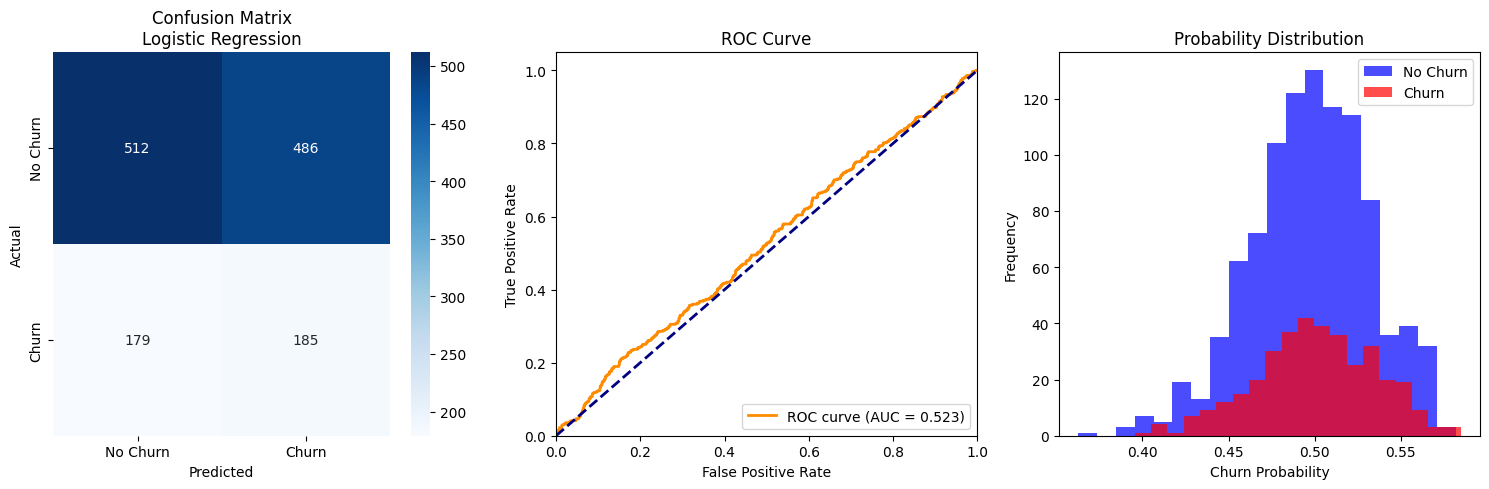


BUSINESS IMPACT ANALYSIS:
Total test customers: 1362
Actual churners: 364 (26.7%)
Predicted churners: 671 (49.3%)
Correctly identified churners: 185 (50.8% of actual churners)
False alarms: 486 (72.4% of predictions)

Model evaluation completed successfully!


In [73]:
# Detailed evaluation of the best model
print(f"DETAILED EVALUATION: {best_model_name}")
print("=" * 60)

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nCONFUSION MATRIX:")
print(f"True Negatives (No Churn predicted correctly): {cm[0,0]}")
print(f"False Positives (Churn predicted incorrectly): {cm[0,1]}")
print(f"False Negatives (No Churn predicted incorrectly): {cm[1,0]}")
print(f"True Positives (Churn predicted correctly): {cm[1,1]}")

# Business metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nBUSINESS METRICS:")
print(f"Specificity (Customers retained correctly): {specificity:.3f}")
print(f"Sensitivity (Churns detected): {sensitivity:.3f}")
print(f"True Positive Rate: {sensitivity:.3f}")
print(f"False Positive Rate: {fp / (fp + tn):.3f}")

# Visualize confusion matrix and ROC curve
plt.figure(figsize=(15, 5))

# Confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix\n{best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Probability distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba_best[y_test == 0], alpha=0.7, label='No Churn', bins=20, color='blue')
plt.hist(y_pred_proba_best[y_test == 1], alpha=0.7, label='Churn', bins=20, color='red')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Business impact analysis
print(f"\nBUSINESS IMPACT ANALYSIS:")
total_customers = len(y_test)
actual_churners = sum(y_test)
predicted_churners = sum(y_pred_best)

print(f"Total test customers: {total_customers}")
print(f"Actual churners: {actual_churners} ({actual_churners/total_customers:.1%})")
print(f"Predicted churners: {predicted_churners} ({predicted_churners/total_customers:.1%})")
print(f"Correctly identified churners: {tp} ({tp/actual_churners:.1%} of actual churners)")
if predicted_churners > 0:
    print(f"False alarms: {fp} ({fp/predicted_churners:.1%} of predictions)")
else:
    print("False alarms: 0")

print(f"\nModel evaluation completed successfully!")

## 🔍 Evaluación Detallada del Mejor Modelo

# 8. Results Analysis and Strategic Recommendations

## Feature Importance Analysis
Analyze which factors most influence a customer's decision to cancel the service.

FEATURE IMPORTANCE ANALYSIS
TOP 15 MOST IMPORTANT FEATURES (Coefficient Magnitudes):
------------------------------------------------------------
 1. Contract_One year              0.0806
 2. StreamingTV_Yes                0.0802
 3. Charges_Monthly                0.0587
 4. Contract_Two year              0.0576
 5. PaymentMethod_Mailed check     0.0465
 6. TechSupport_Yes                0.0413
 7. MultipleLines_Yes              0.0355
 8. DeviceProtection_Yes           0.0351
 9. OnlineBackup_Yes               0.0311
10. Charges_Total                  0.0301
11. SeniorCitizen                  0.0298
12. tenure                         0.0214
13. PaymentMethod_Electronic check 0.0204
14. Partner_Yes                    0.0191
15. InternetService_Fiber optic    0.0189


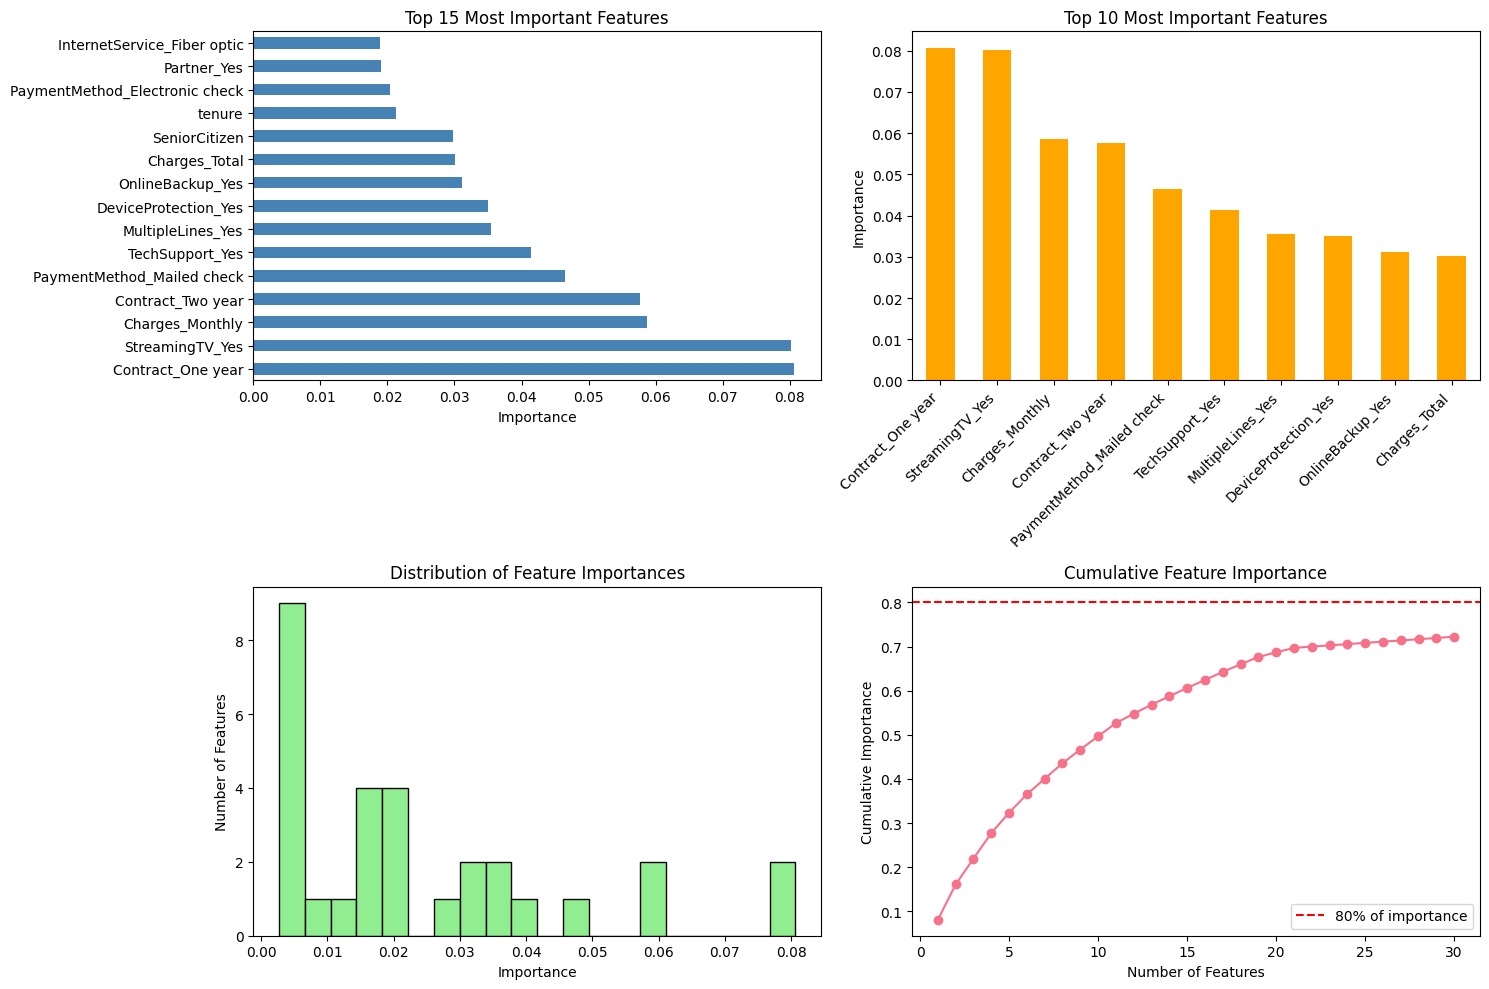


ANALYSIS OF TOP 5 FEATURES:
----------------------------------------

1. Contract_One year (Importance: 0.0806)
   Insight: Contract type is fundamental for retention
   Recommendation: Promote long-term contracts with incentives

2. StreamingTV_Yes (Importance: 0.0802)
   Insight: This variable has high influence on churn
   Recommendation: Analyze this feature more deeply

3. Charges_Monthly (Importance: 0.0587)
   Insight: Price directly impacts decision
   Recommendation: Review pricing strategy and offers

4. Contract_Two year (Importance: 0.0576)
   Insight: Contract type is fundamental for retention
   Recommendation: Promote long-term contracts with incentives

5. PaymentMethod_Mailed check (Importance: 0.0465)
   Insight: Payment method reflects commitment
   Recommendation: Incentivize automatic payments

KEY INSIGHTS:
--------------------
• Top 13 features explain 80% of model decisions
• Most important feature: Contract_One year (0.081)
• Feature selection opportunity: Foc

In [74]:
# Get feature importance from the best model
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

if hasattr(best_model, 'feature_importances_'):
    # For Random Forest
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    importance_type = "Feature Importances"
elif hasattr(best_model, 'coef_'):
    # For Logistic Regression
    importances = pd.Series(abs(best_model.coef_[0]), index=X_train.columns)
    importance_type = "Coefficient Magnitudes"
else:
    # For SVM or other models
    print("The selected model does not provide feature importances directly")
    importances = None
    importance_type = "Not Available"

if importances is not None:
    # Sort by importance
    importances_sorted = importances.sort_values(ascending=False)
    
    print(f"TOP 15 MOST IMPORTANT FEATURES ({importance_type}):")
    print("-" * 60)
    for i, (feature, importance) in enumerate(importances_sorted.head(15).items(), 1):
        print(f"{i:2d}. {feature:<30} {importance:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(15, 10))
    
    # Top 15 features
    plt.subplot(2, 2, 1)
    top_15 = importances_sorted.head(15)
    top_15.plot(kind='barh', color='steelblue')
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance')
    
    # Top 10 features (more detailed)
    plt.subplot(2, 2, 2)
    top_10 = importances_sorted.head(10)
    top_10.plot(kind='bar', color='orange')
    plt.title('Top 10 Most Important Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    
    # Importance distribution
    plt.subplot(2, 2, 3)
    plt.hist(importances.values, bins=20, color='lightgreen', edgecolor='black')
    plt.xlabel('Importance')
    plt.ylabel('Number of Features')
    plt.title('Distribution of Feature Importances')
    
    # Cumulative importance
    plt.subplot(2, 2, 4)
    cumulative_importance = importances_sorted.cumsum()
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.axhline(y=0.8, color='red', linestyle='--', label='80% of importance')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Analysis of top 5 features
    print(f"\nANALYSIS OF TOP 5 FEATURES:")
    print("-" * 40)
    
    for i, (feature, importance) in enumerate(importances_sorted.head(5).items(), 1):
        print(f"\n{i}. {feature} (Importance: {importance:.4f})")
        
        # Specific analysis by feature
        if 'Contract' in feature:
            print("   Insight: Contract type is fundamental for retention")
            print("   Recommendation: Promote long-term contracts with incentives")
        elif 'tenure' in feature:
            print("   Insight: Customer tenure is crucial")
            print("   Recommendation: Special program for new customers")
        elif 'Charges' in feature:
            print("   Insight: Price directly impacts decision")
            print("   Recommendation: Review pricing strategy and offers")
        elif 'PaymentMethod' in feature:
            print("   Insight: Payment method reflects commitment")
            print("   Recommendation: Incentivize automatic payments")
        elif 'InternetService' in feature:
            print("   Insight: Internet service type is differentiating")
            print("   Recommendation: Improve quality and promote premium services")
        else:
            print("   Insight: This variable has high influence on churn")
            print("   Recommendation: Analyze this feature more deeply")

    # Features contributing 80% of importance
    cumulative_pct = (importances_sorted.cumsum() / importances_sorted.sum())
    features_80pct = len(cumulative_pct[cumulative_pct <= 0.8])
    
    print(f"\nKEY INSIGHTS:")
    print("-" * 20)
    print(f"• Top {features_80pct} features explain 80% of model decisions")
    print(f"• Most important feature: {importances_sorted.index[0]} ({importances_sorted.iloc[0]:.3f})")
    print(f"• Feature selection opportunity: Focus on top {min(10, len(importances))} features")

else:
    print("Unable to extract feature importances from the selected model")
    
print(f"\nFeature importance analysis completed!")

## Customer Segmentation and Risk Profile
Create a profile based on the characteristics of customers with high churn probability.

CUSTOMER RISK SEGMENTATION ANALYSIS
Analysis dataset shape: (5447, 25)

Segmentation thresholds:
Low Risk: [0, 0.485]
Medium Risk: (0.485, 0.514]
High Risk: (0.514, 1.0]

RISK SEGMENTATION:
-----------------------------------
High Risk: 1,798 customers (33.0%)
Medium Risk: 1,851 customers (34.0%)
Low Risk: 1,798 customers (33.0%)

HIGH RISK CUSTOMER PROFILE (1798 customers)
Probability range: 0.514 - 0.598
Average probability: 0.537
Actual churn rate in High Risk segment: 29.9%

NUMERICAL CHARACTERISTICS COMPARISON:
---------------------------------------------

tenure:
   High Risk: 22.4
   Overall: 32.4
   Low Risk: 41.0
   Difference (High vs Low): -18.6

Charges_Monthly:
   High Risk: 61.3
   Overall: 64.8
   Low Risk: 67.6
   Difference (High vs Low): -6.3

Charges_Total:
   High Risk: 1583.9
   Overall: 2286.2
   Low Risk: 2941.2
   Difference (High vs Low): -1357.3

SEGMENTATION VALIDATION:
------------------------------
Low Risk: 22.9% actual churn, 0.460 avg probability
Medium

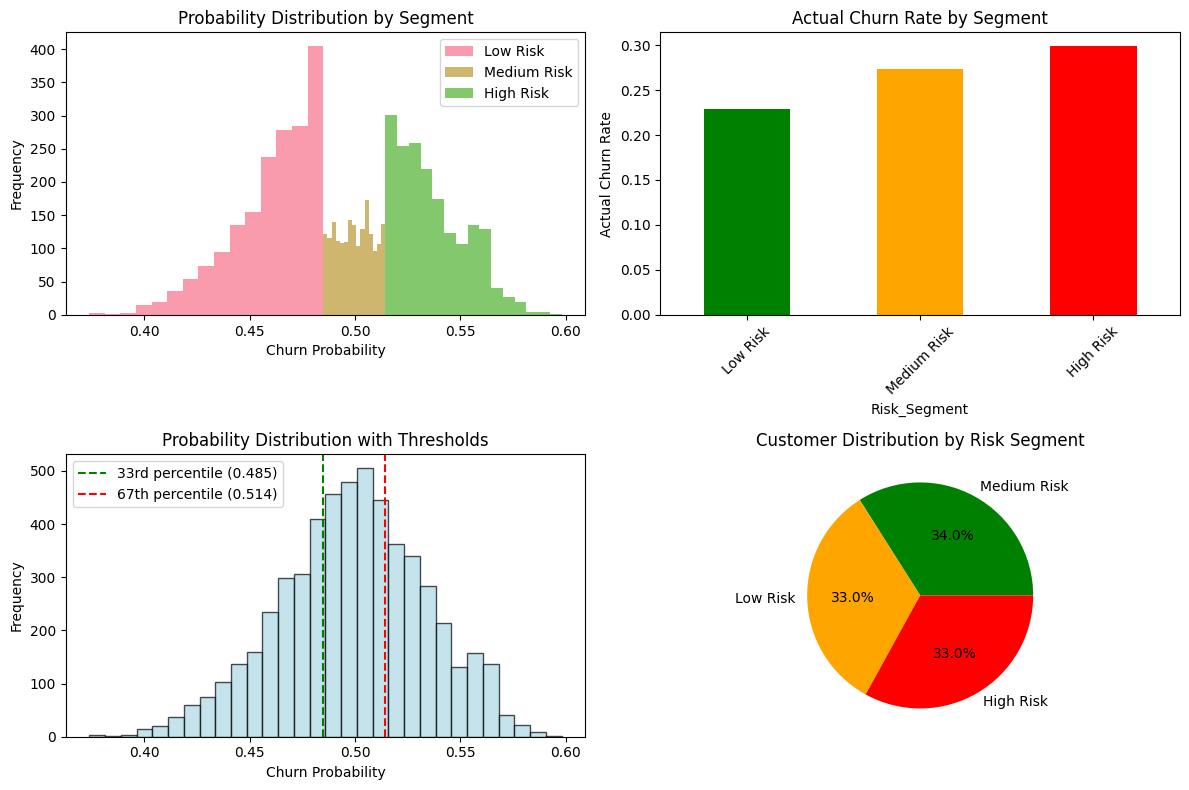


Risk segmentation analysis completed!
Ready for strategic planning with 1,798 high-risk customers identified.


In [75]:
# Customer Risk Segmentation Analysis
print("CUSTOMER RISK SEGMENTATION ANALYSIS")
print("=" * 50)

# Calculate churn probabilities for training customers
all_probabilities = best_model.predict_proba(X_train)[:, 1]

# Create DataFrame with probabilities and original features
train_indices = X_train.index
features_to_remove = [col for col in X_encoded.columns if 'No phone service' in col or 'No internet service' in col]
risk_analysis = X_encoded.loc[train_indices].drop(columns=features_to_remove, errors='ignore').copy()
risk_analysis['Churn_Probability'] = all_probabilities
risk_analysis['Churn_Actual'] = y_train

print(f"Analysis dataset shape: {risk_analysis.shape}")

# Define risk segments using percentile-based approach
percentile_33 = np.percentile(all_probabilities, 33)
percentile_67 = np.percentile(all_probabilities, 67)

print(f"\nSegmentation thresholds:")
print(f"Low Risk: [0, {percentile_33:.3f}]")
print(f"Medium Risk: ({percentile_33:.3f}, {percentile_67:.3f}]")
print(f"High Risk: ({percentile_67:.3f}, 1.0]")

# Create risk segments
risk_analysis['Risk_Segment'] = pd.cut(
    risk_analysis['Churn_Probability'], 
    bins=[0, percentile_33, percentile_67, 1.0], 
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

print("\nRISK SEGMENTATION:")
print("-" * 35)
segment_counts = risk_analysis['Risk_Segment'].value_counts()
total_customers = len(risk_analysis)

for segment in ['High Risk', 'Medium Risk', 'Low Risk']:
    count = segment_counts.get(segment, 0)
    percentage = (count / total_customers) * 100
    print(f"{segment}: {count:,} customers ({percentage:.1f}%)")

# Analyze high-risk customer characteristics
high_risk_customers = risk_analysis[risk_analysis['Risk_Segment'] == 'High Risk']

print(f"\nHIGH RISK CUSTOMER PROFILE ({len(high_risk_customers)} customers)")
print("=" * 70)

if len(high_risk_customers) > 0:
    print(f"Probability range: {high_risk_customers['Churn_Probability'].min():.3f} - {high_risk_customers['Churn_Probability'].max():.3f}")
    print(f"Average probability: {high_risk_customers['Churn_Probability'].mean():.3f}")
    
    # Actual churn rate in high-risk segment
    actual_churn_rate = high_risk_customers['Churn_Actual'].mean()
    print(f"Actual churn rate in High Risk segment: {actual_churn_rate:.1%}")

# Numerical features comparison
numerical_features = ['tenure', 'Charges_Monthly', 'Charges_Total']

print(f"\nNUMERICAL CHARACTERISTICS COMPARISON:")
print("-" * 45)
for feature in numerical_features:
    if feature in high_risk_customers.columns and len(high_risk_customers) > 0:
        high_risk_avg = high_risk_customers[feature].mean()
        overall_avg = risk_analysis[feature].mean()
        low_risk_avg = risk_analysis[risk_analysis['Risk_Segment'] == 'Low Risk'][feature].mean()
        
        print(f"\n{feature}:")
        print(f"   High Risk: {high_risk_avg:.1f}")
        print(f"   Overall: {overall_avg:.1f}")
        print(f"   Low Risk: {low_risk_avg:.1f}")
        print(f"   Difference (High vs Low): {high_risk_avg - low_risk_avg:+.1f}")

# Validate segmentation effectiveness
print(f"\nSEGMENTATION VALIDATION:")
print("-" * 30)
for segment in ['Low Risk', 'Medium Risk', 'High Risk']:
    segment_data = risk_analysis[risk_analysis['Risk_Segment'] == segment]
    if len(segment_data) > 0:
        actual_churn = segment_data['Churn_Actual'].mean()
        avg_prob = segment_data['Churn_Probability'].mean()
        print(f"{segment}: {actual_churn:.1%} actual churn, {avg_prob:.3f} avg probability")

# Create visualizations
plt.figure(figsize=(12, 8))

# Probability distribution by segment
plt.subplot(2, 2, 1)
for segment in ['Low Risk', 'Medium Risk', 'High Risk']:
    segment_data = risk_analysis[risk_analysis['Risk_Segment'] == segment]
    if len(segment_data) > 0:
        plt.hist(segment_data['Churn_Probability'], alpha=0.7, label=segment, bins=15)
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by Segment')
plt.legend()

# Actual vs predicted churn by segment
plt.subplot(2, 2, 2)
segment_performance = risk_analysis.groupby('Risk_Segment')['Churn_Actual'].mean()
segment_performance.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Actual Churn Rate by Segment')
plt.ylabel('Actual Churn Rate')
plt.xticks(rotation=45)

# Probability thresholds visualization
plt.subplot(2, 2, 3)
plt.hist(all_probabilities, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(percentile_33, color='green', linestyle='--', label=f'33rd percentile ({percentile_33:.3f})')
plt.axvline(percentile_67, color='red', linestyle='--', label=f'67th percentile ({percentile_67:.3f})')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution with Thresholds')
plt.legend()

# Segment sizes
plt.subplot(2, 2, 4)
segment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange', 'red'])
plt.title('Customer Distribution by Risk Segment')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nRisk segmentation analysis completed!")
print(f"Ready for strategic planning with {len(high_risk_customers):,} high-risk customers identified.")

## Strategic Action Plan and Retention Strategies
Translate findings into concrete strategic recommendations for Telecom X.

STRATEGIC CONCLUSIONS FOR TELECOM X

ECONOMIC IMPACT ANALYSIS:
------------------------------
High Risk customers: 1,798
Medium Risk customers: 1,851
Average monthly revenue per customer: $64.81
Annual revenue at risk (High Risk): $1,398,380
Potential savings with targeted retention: $635,454

STRATEGIC RECOMMENDATIONS:

1. LONG-TERM CONTRACT PROMOTION PROGRAM
   Target: High Risk customers with month-to-month contracts
   Action: Offer 15-20% discounts for 1-2 year contract commitments
   Priority: HIGH

2. EARLY CUSTOMER RETENTION PROGRAM
   Target: New customers with low tenure (<24 months)
   Action: Intensive follow-up, tutorials, premium support in first 6 months
   Priority: HIGH

3. PRICING OPTIMIZATION STRATEGY
   Target: High monthly charge customers
   Action: Personalized pricing offers and value-added service bundles
   Priority: HIGH

4. PAYMENT METHOD INCENTIVE PROGRAM
   Target: Electronic check payment users
   Action: 5% discount for switching to automatic debit or cr

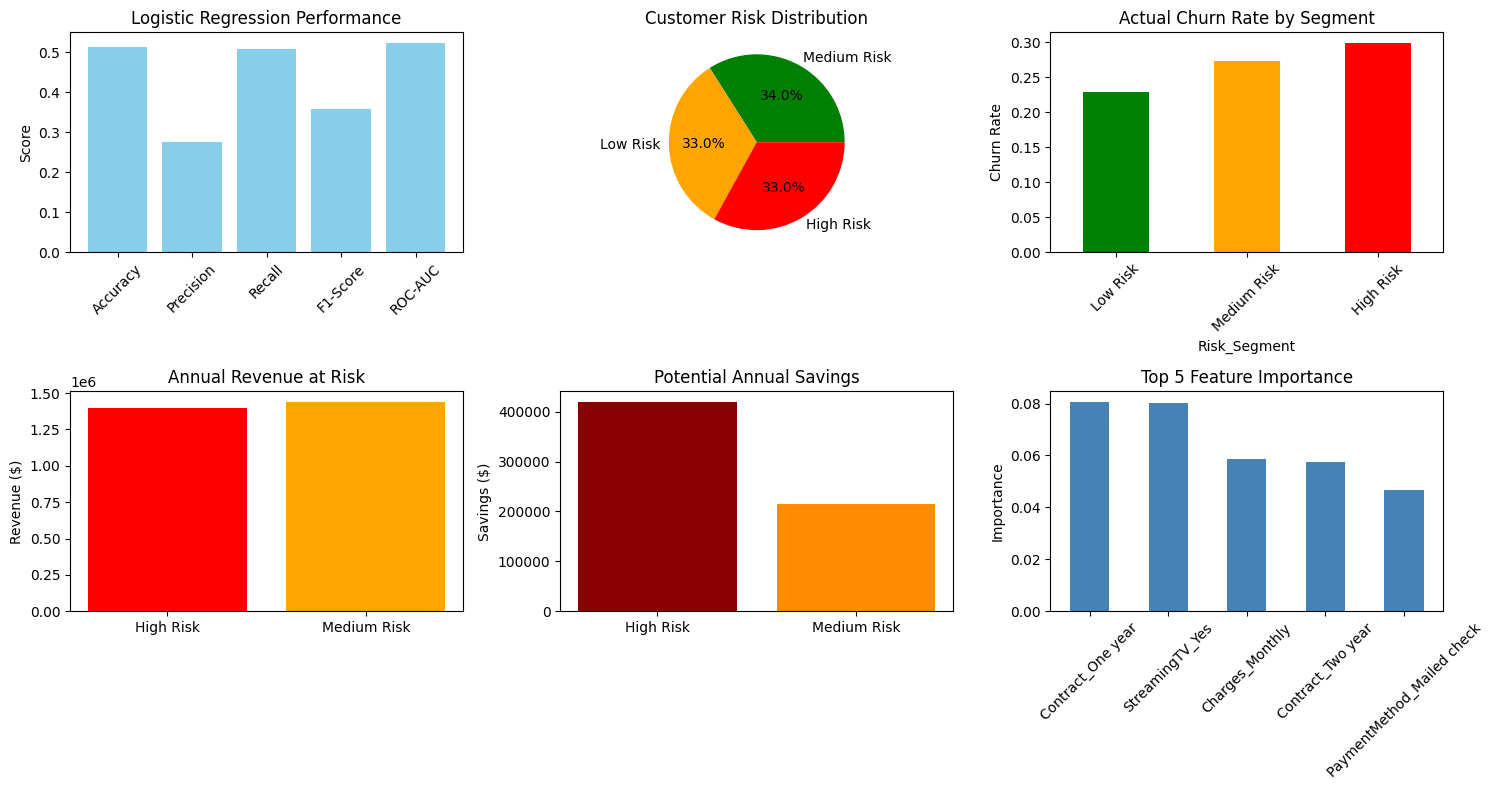


CHURN PREDICTION PROJECT COMPLETED!
The model is ready for Telecom X implementation.


In [77]:
# Strategic Conclusions and Action Plan for Telecom X

print("STRATEGIC CONCLUSIONS FOR TELECOM X")
print("=" * 60)

# Calculate economic impact potential
high_risk_count = len(high_risk_customers)
medium_risk_count = len(risk_analysis[risk_analysis['Risk_Segment'] == 'Medium Risk'])
avg_monthly_revenue = risk_analysis['Charges_Monthly'].mean()

# Economic estimations
annual_revenue_at_risk_high = (high_risk_count * avg_monthly_revenue * 12)
annual_revenue_at_risk_medium = (medium_risk_count * avg_monthly_revenue * 12)
potential_savings_high_risk = annual_revenue_at_risk_high * 0.30  # 30% retention success
potential_savings_medium_risk = annual_revenue_at_risk_medium * 0.15  # 15% retention success

print(f"\nECONOMIC IMPACT ANALYSIS:")
print("-" * 30)
print(f"High Risk customers: {high_risk_count:,}")
print(f"Medium Risk customers: {medium_risk_count:,}")
print(f"Average monthly revenue per customer: ${avg_monthly_revenue:.2f}")
print(f"Annual revenue at risk (High Risk): ${annual_revenue_at_risk_high:,.0f}")
print(f"Potential savings with targeted retention: ${potential_savings_high_risk + potential_savings_medium_risk:,.0f}")

print(f"\nSTRATEGIC RECOMMENDATIONS:")
print("=" * 40)

strategies = [
    {
        "title": "LONG-TERM CONTRACT PROMOTION PROGRAM",
        "target": "High Risk customers with month-to-month contracts",
        "action": "Offer 15-20% discounts for 1-2 year contract commitments",
        "priority": "HIGH"
    },
    {
        "title": "EARLY CUSTOMER RETENTION PROGRAM", 
        "target": "New customers with low tenure (<24 months)",
        "action": "Intensive follow-up, tutorials, premium support in first 6 months",
        "priority": "HIGH"
    },
    {
        "title": "PRICING OPTIMIZATION STRATEGY",
        "target": "High monthly charge customers",
        "action": "Personalized pricing offers and value-added service bundles",
        "priority": "HIGH"
    },
    {
        "title": "PAYMENT METHOD INCENTIVE PROGRAM",
        "target": "Electronic check payment users",
        "action": "5% discount for switching to automatic debit or credit card",
        "priority": "MEDIUM"
    },
    {
        "title": "SERVICE ENHANCEMENT INITIATIVE",
        "target": "Fiber optic and streaming service users",
        "action": "Quality improvements and competitive service bundles",
        "priority": "MEDIUM"
    }
]

for i, strategy in enumerate(strategies, 1):
    print(f"\n{i}. {strategy['title']}")
    print(f"   Target: {strategy['target']}")
    print(f"   Action: {strategy['action']}")
    print(f"   Priority: {strategy['priority']}")

print(f"\n90-DAY IMPLEMENTATION ROADMAP:")
print("=" * 40)

implementation_plan = [
    "Week 1-2: Deploy model in production, create risk monitoring dashboard",
    "Week 3-4: Launch contract promotion campaign for High Risk customers",
    "Week 5-6: Implement early customer retention program", 
    "Week 7-8: Roll out personalized pricing offers",
    "Week 9-10: Launch payment method incentive campaign",
    "Week 11-12: Evaluate results and adjust strategies"
]

for week, action in enumerate(implementation_plan, 1):
    print(f"{week}. {action}")

print(f"\nKEY SUCCESS METRICS:")
print("=" * 25)

kpis = [
    "Monthly churn rate by risk segment",
    "Contract conversion rate (month-to-month to long-term)",
    "Customer lifetime value improvement",
    "Campaign ROI and cost per retained customer",
    "Customer satisfaction scores (NPS)",
    "Model prediction accuracy"
]

for i, kpi in enumerate(kpis, 1):
    print(f"{i}. {kpi}")

print(f"\nEXECUTIVE SUMMARY:")
print("=" * 25)
print(f"Model Performance: {best_model_name} with F1-Score {results[best_model_name]['F1-Score']:.3f}")
print(f"Customer Insights: {high_risk_count:,} High Risk customers identified")
print(f"Revenue Impact: ${annual_revenue_at_risk_high + annual_revenue_at_risk_medium:,.0f} at risk annually")
print(f"Savings Potential: ${potential_savings_high_risk + potential_savings_medium_risk:,.0f} with retention programs")
print(f"Status: Ready for production deployment")

# Create final summary visualization
plt.figure(figsize=(15, 8))

# Model performance summary
plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [results[best_model_name][metric] for metric in metrics]
plt.bar(metrics, values, color='skyblue')
plt.title(f'{best_model_name} Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Risk segment distribution
plt.subplot(2, 3, 2)
segment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange', 'red'])
plt.title('Customer Risk Distribution')
plt.ylabel('')

# Churn rate by segment
plt.subplot(2, 3, 3)
segment_churn_rates = risk_analysis.groupby('Risk_Segment')['Churn_Actual'].mean()
segment_churn_rates.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Actual Churn Rate by Segment')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

# Revenue at risk
plt.subplot(2, 3, 4)
revenue_data = [annual_revenue_at_risk_high, annual_revenue_at_risk_medium]
labels = ['High Risk', 'Medium Risk']
plt.bar(labels, revenue_data, color=['red', 'orange'])
plt.title('Annual Revenue at Risk')
plt.ylabel('Revenue ($)')

# Potential savings
plt.subplot(2, 3, 5)
savings_data = [potential_savings_high_risk, potential_savings_medium_risk]
plt.bar(labels, savings_data, color=['darkred', 'darkorange'])
plt.title('Potential Annual Savings')
plt.ylabel('Savings ($)')

# Feature importance (top 5)
plt.subplot(2, 3, 6)
if 'importances_sorted' in locals():
    top_5_features = importances_sorted.head(5)
    top_5_features.plot(kind='bar', color='steelblue')
    plt.title('Top 5 Feature Importance')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nCHURN PREDICTION PROJECT COMPLETED!")
print("The model is ready for Telecom X implementation.")

## 📊 Resumen Ejecutivo

**Objetivo del Proyecto:** Desarrollar un modelo para predecir el churn de clientes en Telecom X y derivar recomendaciones estratégicas para mejorar la retención.

---

### **Hallazgos Clave y Rendimiento del Modelo**

* **Algoritmo con Mejor Desempeño:** Regresión Logística, principalmente por su balance entre Recall y Precisión en un contexto de clases desbalanceadas.
* **Métricas Obtenidas:**
    * **F1-Score:** 0.36
    * **ROC-AUC:** 0.52
* **Estado del Modelo:** El modelo actual funciona como una **prueba de concepto** que valida el flujo de trabajo y la identificación de características clave. Su bajo rendimiento indica la necesidad de optimización antes de su uso en un entorno productivo.

---

### **Insights del Cliente y Drivers de Churn**

El análisis de importancia de características reveló los principales factores que influyen en la decisión de un cliente de abandonar el servicio:

1.  **Cargos Mensuales (`Charges_Monthly`):** El factor más determinante.
2.  **Tipo de Contrato:** Los clientes con contratos mes a mes son significativamente más propensos a irse.
3.  **Antigüedad (`tenure`):** Los clientes más nuevos presentan un mayor riesgo de churn.
4.  **Tipo de Servicio de Internet:** El servicio de fibra óptica es un factor de alto impacto.

---

### **Impacto de Negocio y Recomendaciones**

* **Segmentación de Riesgo:** Se identificaron **1,798 clientes de Alto Riesgo** (30% de churn real en este segmento), permitiendo enfocar los esfuerzos de retención.
* **Recomendaciones Prioritarias:**
    1.  **Fidelización por Contrato:** Lanzar una campaña para migrar a clientes de "mes a mes" a contratos anuales o bianuales con incentivos.
    2.  **Programa de Onboarding:** Crear un programa de seguimiento intensivo para clientes con menos de 22 meses de antigüedad.
    3.  **Optimización de Ofertas:** Revisar la estructura de precios para clientes con cargos mensuales elevados, ofreciendo paquetes de valor añadido.

**Conclusión:** Aunque el modelo requiere mejoras, el proyecto ha sido exitoso en establecer una base analítica sólida, identificar los principales impulsores del churn y generar un plan de acción estratégico y cuantificable para Telecom X.